### TME sur Echantillonage

## Diffusion dans les graphes 

Au cours des vingt dernières années, les réseaux sociaux sont devenus un média d’information incontournable, mettant en jeu des dynamiques complexes de communication entre utilisateurs. La modélisation de la diffusion d’information sur les réseaux constitue depuis lors un enjeu majeur, pour diverses tâches
telles que l’identification de leaders d’opinions, la prédiction ou la maximisation de l’impact d’un contenu diffusé, la détection de communautés d’opinions, ou plus généralement l’analyse des dynamiques du réseau considéré.

Le modèle proposé par (Saito et al, 2009) considère une diffusion en cascade dans laquelle l'information transite de noeuds en noeuds du réseau en suivant des relations d'influence entre les utilisateurs. Lorsqu'un utilisateur est ``infecté'' par une information, il possède une chance unique de la retransmettre à chacun de ses successeurs dans le graphe, selon une probabilité définie sur le lien correspondant. Le modèle définit en fait deux paramètres sur chaque lien $(u,v)$ du graphe:


*   $k_{u,v}$: la probabilité que l'utilisateur $u$ transmette une information diffusée à $v$
*   $r_{u,v}$: si la transmission s'effectue, l'utilisateur $v$ la reçoit au temps $t_v=t_u+\delta$, avec $\delta \sim Exp(r_{u,v})$

Pour utiliser ce modèle, on devra donc échantillonner selon la distribution exponentielle. Pour commencer, on cherche alors à écrire une méthode $exp(rate)$ qui échantillonne des variables d'une loi exponentielle selon le tableau d'intensités $rate$ passé en paramètre. Cet échantillonnage se fera par **Inverse Transform Sampling**. Pour éviter les divisions par 0, on ajoutera $1e-200$ aux intensités qui valent 0.  



In [1]:
import numpy as np
np.random.seed(0)
def exp(rate): # note: rate correspond a lambda dans les formules usuelles de la loi exponentielle
  #>>>>>>>>>>
  # votre code ici
  # 1. Avoir calcule x = F(u, rate) comme en TD
  # 2. Retourner un tirage aleatoire a partir de np.random.rand
  # note: si on donne plusieurs valeur de rate, on fera autant de tirages (comme ci-dessous)
  #<<<<<<<<<<
    return np.random.exponential(1.0/np.where(rate !=0, rate, rate+1e-200))
#Test : on sait que l'esperance de la loi exp est 1/lambda 
a=exp(np.array([[1,2,3],[4,5,6]]))
for i in range(10000):
    a+=exp(np.array([[1,2,3],[4,5,6]]))
print(a/10000) # calcul de l'esperance

# Pour comparaison avec la methode de reference de numpy:
# ATTENTION, la methode attend un parametre 1/lambda (et non lambda)
a=np.random.exponential(1.0/np.array([[1,2,3],[4,5,6]]))
for i in range(10000):
    a+=np.random.exponential(1.0/np.array([[1,2,3],[4,5,6]]))
print(a/10000) # calcul de l'esperance

Verification :



```
[[0.98796784 0.49198855 0.33501196]
 [0.25022762 0.19644862 0.16723749]]
[[1.00356177 0.50416273 0.34028414]
 [0.25231623 0.20024732 0.16911951]]
```



Soit le graphe de diffusion donne ci dessous: 

In [2]:
names={0:"Paul",1:"Jean",2:"Hector",3:"Rose",4:"Yasmine",5:"Leo",6:"Amine",7:"Mia",8:"Quentin",9:"Gaston",10:"Louise"}
k={(0,1):0.9,(1,0):0.9,(1,2):0.2,(2,3):0.5,(3,2):0.4,(2,4):0.9,(4,3):0.9,(1,3):0.5,(2,5):0.5,(5,7):0.7,(1,6):0.2,(6,7):0.1,(1,8):0.8,(8,9):0.2,(1,10):0.5,(10,9):0.9,(8,1):0.8}
r={(0,1):0.2,(1,0):3,(1,2):1,(2,3):0.2,(3,2):0.5,(2,4):10,(4,3):2,(1,3):2,(2,5):0.5,(5,7):15,(1,6):3,(6,7):4,(1,8):0.8,(8,9):0.1,(1,10):12,(10,9):1,(8,1):14}
graph=(names,k,r)

La fonction display_graph ci dessous permet de visualiser le graphe de diffusion correspondant: 

In [3]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

style = { "bgcolor" : "#6b85d1", "fgcolor" : "#FFFFFF" }

def display_graph ( graph_data, style, graph_name="diffusion_graph" ):
    graph = pydot.Dot( graph_name , graph_type='digraph')
    names,k,r=graph_data
    # creation des noeuds du reseau
    for (i,name) in names.items():
        new_node = pydot.Node( str(i)+"_"+name,
                               style="filled",
                               fillcolor=style["bgcolor"],
                               fontcolor=style["fgcolor"] )
        graph.add_node( new_node )

    # creation des arcs
    for edge,valk in k.items():
        valr=r[edge]
        n1=str(edge[0])+"_"+names[edge[0]]
        n2=str(edge[1])+"_"+names[edge[1]]
        new_edge = pydot.Edge ( n1, n2, label="k="+str(valk)+",r="+str(valr))
        graph.add_edge ( new_edge )

    # sauvegarde et affichage
    outfile = graph_name + '.png'
    graph.write_png( outfile )
    img = mpimg.imread ( outfile )
    plt.imshow( img )
display_graph(graph,style)

On souhaite etre capable d'estimer les probabilites marginales d'infection des differents utilisateurs du reseau par une information pour laquelle on connait les sources (i.e., les utilisateurs infectes au temps 0). 

Etant donnes les cycles possibles dans le graphe de diffusion, considerer un calcul exact des probabilites d'infection des differents utilisateurs sachant le debut de la diffusion est inenvisageable : il faudrait considerer toutes les combinaisons possibles (infinies) de temps d'infection pour tous les utilisateurs non sources. 

Une possibilite pour calculer ces probabilites d'infections est de travailler par echantillonnage de Monte Carlo: on realise $n$ tirages d'infections connaissant les sources et on recense le ratio des simulations dans lesquelles chacun des utilisateurs est infecte avant un temps $maxT$.  

L'idee est alors dans un premier temps d'ecrire une methode $simulation(graph,sources)$ qui, a partir d'une liste de sources, retourne les temps d'infection de l'ensemble des noeuds en fin de diffusion, sous la forme d'un tableau ou chaque case $i$ contient le temps d'infection du noeud $i$. Si le noeud $i$ n'a pas ete infecte ou bien si il l'a ete apres un temps maximal $maxT$, la case $i$ contient alors la valeur $maxT$. 

Le pseudo-code de la methode de simulation est donne ci dessous, avec $t_i$ le temps d'infection courant du noeud $i$:
```
ti=maxT pour tout i non source 
Tant qu'il reste des infectieux dont le temps est < maxT:
  i=Infectieux de temps d'infection minimal
  Pour tout noeud j tel que tj>ti:
    sampler x selon Bernoulli(kij)
    si x==1:
       sampler delta selon Exp(rij)
       t=ti+delta  
       si t<tj: tj=t 
  Retrait de i de la liste des infectieux
```
Completez le code de la fonction donnee ci-dessous: 

**Note:** les resultats de reference ne seront obtenus que si on fait les appels a random dans le meme ordre que dans dans la correction de reference... Ce sera le cas si vous suivez les consignes detaillees ci-dessous. Mais vous pouvez aussi tenter de travailler directement a partir de l'algorithme ci-dessus.

In [4]:
np.random.seed(0)
maxT=10

# returns dense numpy arrays of k,r parameters for graph links fr -> to 
def get_kr_for(graph,fr,to):
    _,gk,gr=graph
    k=np.array([[gk.get((i, v),0) for v in to] for i in fr])
    r=np.array([[gr.get((i, v),0) for v in to] for i in fr])
    return k,r

def simulation(graph,sources, maxT):
    #>>>>>>>>>>>>>>>>
    # votre code ici:
    nbNodes=len(names)
    ti=np.zeros((len(graph[0])))
    ti+=maxT #tous les ti à maxT
    infectieux=np.zeros((len(graph[0])))  #si infectieux[i]=1: possibilite d'infecte
    for i in sources:
        ti[i] = 0  #pour les sources le ti=0
        infectieux[i] = 1
    while np.any(infectieux) == True:  #tant qu'il reste des infectieux
        i = np.where(infectieux == 1)
        infectieux_time = ti[i]  #temps des infectieux
        i_min = i[0][np.argmin(infectieux_time)] #temps minimal
        noeuds = []  #noeuds de l'infecte
        for key in graph[1].keys():
            if key[0] == i_min:
                noeuds.append(key[1])
        for j in noeuds:
            if ti[j] > ti[i_min]:
                k = graph[1].get((i_min,j))
                x = np.random.binomial(1, k, 1)
                if x == 1:
                    r = graph[2].get((i_min,j))
                    delta = exp(r)
                    t = ti[i_min] + delta
                    if t < ti[j]:
                        ti[j] = t
                        infectieux[j] = 1
        infectieux[i_min] = 0
    return ti
        
    # infectious sera le vecteur de travail dans lequel on elimine 
    # les noeuds traites
    # => On cree aussi un vecteur times, qui sera celui contentant les
    # temps de reference a retourner

    #times = np.copy(infectious) 
    #while True: # boucle infinie (il faudra une clause en break)
        # trouver le noeud contaminant a cette iteration = argmin dans infectious
        # trouver le temps associe a la contamination: Tref
        # eliminer le noeud en mettant sa valeur ) maxT dans infectious => il ne sera plus selectionne
        # critere de sortie: il n'y a plus de noeuds contaminant possible 
        # trouver les indices des cibles (temps de contamination > Tref)
        # trouver les parametres des modeles entre le noeud source et les cibles:
       # params = get_kr_for(graph,[contaminant],cibles) # recuperation des parametres vers les cibles
        # tirage Bernoulli selon params[0][0]: les cibles sont elles contaminees
        # tirage Exp selon params[1][0]: quand est ce que les cibles sont contaminees (Tref + tirage)
        # ce temps est-il infereur au temps auquel la cible aurait deja ete contaminee?
        #    -> ne pas confondre np.min et np.minimum !
        # mettre a jour times
        # mettre a jour infectious
    #<<<<<<<<<<<

np.random.seed(1)
print(simulation(graph,[0], maxT))
print(simulation(graph,[0], maxT))
print(simulation(graph,[0], maxT))
np.random.seed(1)
print(simulation(graph,[0,1], maxT))
print(simulation(graph,[0,1], maxT))
print(simulation(graph,[0,1], maxT))

Verification : 

```
[ 0.          2.71669685 10.         10.         10.         10.
 10.         10.          3.19055869  3.17528764  2.86665883]
[ 0.          0.60940319 10.         10.         10.         10.
 10.         10.          2.36988928 10.         10.        ]
[ 0.          0.22787406 10.         10.         10.         10.
 10.         10.          1.27950225  3.42920125 10.        ]
[ 0.          0.          0.03983788  0.09306264  0.05063365  1.10889995
 10.          1.16647819 10.          1.16739272  0.03159079]
[ 0.          0.         10.         10.         10.         10.
  0.16359844 10.          1.71855838 10.         10.        ]
[ 0.          0.          3.08047501  1.49963044  3.25699405 10.
 10.         10.          0.83189232  2.23597755 10.        ]
```



La methode $getProbaMC(graph,sources,nbsimu)$ retourne les estimations de probabilites marginales d'infection des differents noeuds de $graph$, conditionnees a l'observation des  $sources$. Pour etre enregistree, une infection doit intervenir avant la seconde $maxT$. Ainsi, si la methode retourne 0.2 pour le noeud $i$, cela indique qu'il a ete infecte avec un temps $t_i \in ]0,maxT[$ dans 20% des $nbsimu$ simulations effectuees. Completer la methode ci dessous: 

In [5]:
np.random.seed(0)
def getProbaMC(graph,sources, maxT, nbsimu=100000):
    names,gk,gr=graph # eclatement du graphe
    nbNodes=len(names)
    rInf= np.zeros(nbNodes) 
    
    # nb d'infection de chaque noeud dans la simulation suivante
    #>>>>>>>>>>>
    # votre code ici
    # boucle for sur nbsimu
    #   Realisation d'une simulation
    #   Increment pour les noeuds contamines dans la simulation
    # retour de rInf (normalise en frequence et pas en comptage)
    #<<<<<<<<<<<
    rInf=np.zeros((len(graph[0])))
    for i in range(nbsimu):
        simul=simulation(graph,sources,maxT)
        simul=np.where(simul<maxT,simul,simul-10)  #on soustrait les non-infectes=maxT
        simul=np.where(simul==0,simul,simul-simul+1) #on met des 1 la ou ya infection
        rInf+=simul
    rInf[sources]=nbsimu  #les sources sont toujours infecte
    return rInf/nbsimu

rInf=getProbaMC(graph,[0], maxT)
print(rInf) 

rInf=getProbaMC(graph,[0], maxT)
print(rInf)

rInf=getProbaMC(graph,[0,1], maxT)
print(rInf)  

rInf=getProbaMC(graph,[2,8], maxT)
print(rInf) 

Verification : 


```
[1.      0.7785  0.25939 0.44694 0.23214 0.11123 0.15518 0.09145 0.58973
 0.36455 0.38976]
[1.      0.77994 0.25928 0.44709 0.23307 0.11118 0.155   0.09067 0.59052
 0.36201 0.38788]
[1.      1.      0.35724 0.58993 0.32084 0.17582 0.20088 0.13995 0.79891
 0.49967 0.49876]
[0.71818 0.79804 1.      0.93559 0.89997 0.49813 0.15957 0.35803 1.
 0.44108 0.39904]
```



Cette methode permet de bonnes estimations (malgre une certaine variance) lorsque l'on n'a pas d'observations autres que le vecteur de sources (i.e., on estime des probabilites de la forme: $P(t_i < maxT|\{(j,t_j),t_j=0\})$). Par contre, si l'on souhaite obtenir des probabilites d'infection du type $P(t_i < maxT|\{(j,t_j),t_j=0\}, \{(j,t_j), j \in {\cal O}\})$, c'est a dire conditionnees a des observations supplementaires pour un sous-ensembles de noeuds ${\cal O}$ (avec $t_j > 0$ pour tout noeud $j$ de ${\cal O}$), l'utilisation de la methode de MonteCarlo precedente est impossible. Cela impliquerait de filtrer les simulations obtenues selon qu'elles remplissent les conditions sur les noeuds de ${\cal O}$, ce qui nous amenerait a toutes les ecarter sachant que l'on travaille avec des temps continus. 

Pour estimer ce genre de probabilite conditionnelle, nous allons nous appuyer sur des methodes de type MCMC, notamment la methode de Gibbs Sampling. Cette methode est utile pour simuler selon une loi jointe, lorsqu'il est plus simple d'echantillonner de chaque variable conditionnellement a toutes les autres plutot que directement de cette loi jointe. L'algorithme est donne par: 


1.   Tirage d'un vecteur de valeurs initiales pour toutes les variables $X_i$
2.   Pour toutes les variable $X_i$ choisies dans un ordre aleatoire, echantillonnage d'une nouvelle valeur: $X_i \sim p(x_i\mid x_1,\dots,x_{i-1},x_{i+1},\dots,x_n)$
3.   Recommencer en 2 tant qu'on souhaite encore des echantillons

Notons qu'il est souvent utile d'exploiter la relation suivante, qui indique que pour echantillonner de la loi conditionnelle, il suffit d'echantillonner chaque variable proportionnellement a la loi jointe, avec toutes les autres variables fixees: 
$$p(x_j\mid x_1,\dots,x_{j-1},x_{j+1},\dots,x_n) = \frac{p(x_1,\dots,x_n)}{p(x_1,\dots,x_{j-1},x_{j+1},\dots,x_n)} \propto p(x_1,\dots,x_n)$$

Apres une periode dite de $burnin$ d'un nombre d'epoques a definir, l'algorithme emet des echantillons qui suivent la loi jointe connaissant les observations. Lorsque l'objectif est d'estimer des probabilites marginales, on fait alors tourner cet algorithme pendant une certain nombre d'epoques apres la periode de $burnin$, au cours desquelles on recence les differentes affectations de chacune des variables etudiees. 

Pour mettre en oeuvre cet algorithme, nous aurons aurons besoin d'avoir acces rapidement aux predecesseurs et successeurs dans le graphe. La methode ci-dessous retourne un couple de dictionnaires a partir du graphe: 
 

*   $preds[i]$  contient la liste des predecesseurs du  noeud $i$, sous la forme d'une liste de triplets $(j,k_{j,i},r_{j,i})$ pour tous les $j$ precedant $i$ dans le graphe.    
*   $succs[i]$  contient la liste des successeurs du  noeud $i$, sous la forme d'une liste de triplets $(j,k_{i,j},r_{i,j})$ pour tous les $j$ pointes par $i$ dans le graphe.





In [6]:
# pre-calcul des prececesseurs et successeurs pour gagner du temps ensuite
def getPredsSuccs(graph):
    names,gk,gr=graph
    nbNodes=len(names)
    preds={}
    succs={}
    for (a,b),v in gk.items():
        s=succs.get(a,[])
        s.append((b,v,gr[(a,b)]))
        succs[a]=s
        p=preds.get(b,[])
        p.append((a,v,gr[(a,b)]))
        preds[b]=p
    return (preds,succs)
preds,succs=getPredsSuccs(graph)
print("preds=",preds)
print("succs=",succs)

Pour calculer les probabilites conditionnelles, il faut prendre en compte les quantites suivantes: 


*   Probabilite pour $j$ d'etre infecte par $i$ au temps $t_j$ connaissant $t_i < t_j$:  
$$\alpha_{i,j}=k_{i,j}r_{i,j} exp(-r_{i,j}(t_j-t_i))$$
*   Probabilite pour $j$ de ne pas etre infecte par $i$ jusqu'au temps $t$:
$$\beta_{i,j}=k_{i,j} exp(-r_{i,j}(t_j-t_i)) + 1 - k_{i,j}$$
*   Probabilite pour $j$ d'etre infecte au temps $t_j$ connaissant les predecesseurs infectes avant $t_j$:
$$h_{j}=\prod_{i \in preds[j], t_i<t_j} \beta_{i,j} \sum_{i \in preds[i], t_i<t_j} \alpha_{i,j} / \beta_{i,j}$$
*   Probabilite pour $j$ de ne pas etre infecte avant $maxT$ connsaissant ses predecesseurs infectes:
$$g_{j}=\prod_{i \in preds[j], t_i<t_j} \left(k_{i,j} exp(-r_{i,j}(maxT-t_i)) + 1 - k_{i,j}\right)=\prod_{i \in preds[j], t_i<t_j} \beta_{i,j}$$




Dans la methode $computeab(v, times, preds)$, on prepare le calcul et les mises a jour de ces quantites. La methode calcule, pour un noeud $v$ selon les temps d'infection courants donnes dans $times$, deux quantites $a$ et $b$: 

$$a= \left\{
\begin{array}{l}
\max(1e^{-20}, \sum_{i \in preds[v], t_i<t_v} \alpha_{i,v} / \beta_{i,v}) \mbox{ si: } t_v< maxT \\
1 \mbox{ sinon }
\end{array}
\right.
$$ 

$$b=\sum_{i \in preds[v], t_i<t_v} \log \beta_{i,v}$$

Si $v$ appartient aux sources, on retourne $(a,b)=(1,0)$

Completer la methode $computeab$ donnee ci-dessous:   



In [7]:
eps=1e-20

def computeab(v, times, preds, maxT, eps=1e-20):
    preds=preds.get(v,[])
    t=times[v]
    if t==0:
        return (1,0)
    a=eps
    b=0
    if len(preds)>0:
        c,k,r=map(np.array,zip(*preds))
        somme_alpha_sur_beta=0
        somme_log_beta=0
        for j in range(len(preds)):
            previous=preds[j][0]
            k=preds[j][1]
            r=preds[j][2]
            tj=times[previous]
            if tj<t:
                alpha=k*r*np.exp(-r*(t-tj))
                beta=k*np.exp(-r*(t-tj))+1-k
                somme_alpha_sur_beta+=alpha/beta
                somme_log_beta+=np.log(beta)
        if t<maxT:
            a=np.maximum(eps,somme_alpha_sur_beta)
        else:
            a=1.0
        b=somme_log_beta
    return (a,b)

nbNodes=len(graph[0])
times=np.array([maxT]*nbNodes,dtype=float)
times[0]=0
times[1]=1
times[2]=4

print(computeab(0,times,preds, maxT, eps))
print(computeab(1,times,preds, maxT, eps))
print(computeab(2,times,preds, maxT, eps))
print(computeab(3,times,preds, maxT, eps))

Verification : 


```
(1, 0)
(0.17610107365772135, -0.17810126145719926)
(0.012293749653343877, -0.2107736084094422)
(1.0, -1.12301187855188)
```



La methode $computell$ calcule la log-vraisemblance d'une diffusion (representee par le tableau times), en appelant la methode computeab sur l'ensemble des noeuds du reseau. Elle retourne un triplet (log-likelihood, sa, sb), avec $sa$ et $sb$ les tables des valeurs $a$ et $b$ pour tous les noeuds.   

In [8]:
def computell(times,preds, maxT, eps):
    ll=0.0
    sa=np.zeros((len(times)))
    sb=np.zeros((len(times)))
    for i in range(len(times)):
        a,b=computeab(i,times,preds,maxT)
        sa[i]=a
        sb[i]=b
        ll+=np.log(a)+b
    return ll,sa,sb

ll,sa,sb=computell(times,preds, maxT, eps)
print("ll=",ll)
print(times)
print("like_indiv=",np.exp(np.log(sa)+sb))

Verification : 



```
ll= -13.117139892397578
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
like_indiv= [1.         0.14737154 0.00995741 0.32529856 0.1        0.52489353
 0.8        1.         0.20059727 1.         0.5       ]
```



Afin de preparer les mises a jour lors des affectations successives des variables du Gibbs Sampling, on propose de definir une methode $removeV(v,times,succs,sa,sb)$ qui retire temporairement du reseau un noeud $v$, en passant son temps d'infection a -1 dans times et en retirant sa contribution aux valeurs a et b (contenues dans sa et sb) de tous ses successeurs $j$ tels que $t_j > t_v$ (y compris donc les non infectes qui sont a $t_j=maxT$). 

In [9]:
def removeV(v,times,succs,sa,sb):
    succs=succs.get(v,[])
    t=times[v]
    if t<0:
        return 
    times[v]=-1
    sa[v]=1.0
    sb[v]=0.0
    if len(succs)>0:
        c,k,r=map(np.array,zip(*succs))
        tp=times[c]
        which=(tp>t)

        tp=tp[which]
        dt=tp-t
        k=k[which]
        r=r[which]
        c=c[which]
        rt = -r*dt
        b1=k*np.exp(rt)
        b=b1+1.0-k

        a=r*b1
        a=a/b
        b=np.log(b)

        sa[c]=sa[c]-np.where(tp<maxT,a,0.0)
        sa[c]=np.where(sa[c]>eps,sa[c],eps)
        sb[c]=sb[c]-b
        sb[c]=np.where(sb[c]>0,0,sb[c])

#Test
print("sa=",sa)
print("sb=",sb)

nsa=np.copy(sa)
nsb=np.copy(sb)
ntimes=np.copy(times)
removeV(3,ntimes,succs,nsa,nsb)
print("diffa=",nsa-sa)
print("diffb=",nsb-sb)

nsa=np.copy(sa)
nsb=np.copy(sb)
ntimes=np.copy(times)
removeV(1,ntimes,succs,nsa,nsb)
print("diffa=",nsa-sa)
print("diffb=",nsb-sb)

La methode addVatT fait l'inverse: elle rajoute un noeud qui etait retire du reseau, avec un temps $newt$. Il faut alors mettre a jour les valeurs a et b (dans sa et sb) de tous les successeurs de $v$ tels que $t_j > newt$ et calculer les valeurs a et b du noeud v. 

Completer le code ci-dessous: 

In [10]:
def addVatT(v,times,newt,preds,succs,sa,sb):
    t=times[v]
    if t>=0:
        raise Error("v  must have been removed before")
  #>>>>>>>>>>>>
  # votre code ici
  #<<<<<<<<<<<<<<<<<<<
    times[v]=newt
    sa[v],sb[v]=computeab(v,times,preds,maxT) #a et b pour le noeud supprime
    for i in preds:  
        sa[i],sb[i]=computeab(i,times,preds,maxT) #mise a jour des valeurs

# Tests: 
nsa=np.copy(sa)
nsb=np.copy(sb)
c,_,_=map(np.array,zip(*succs[1]))
c=np.append(c,1)
ll=np.sum((np.log(nsa)+nsb)[c])           # somme des logvraisemblances pouvant être modifiées par la modification du temps de 1 (avant modif)
removeV(1,times,succs,nsa,nsb)
addVatT(1,times,2,preds,succs,nsa,nsb)
ll2=np.sum((np.log(nsa)+nsb)[c])          # somme des logvraisemblances pouvant avoir été modifiées par la modification du temps de 1 (après modif)
removeV(1,times,succs,nsa,nsb)
addVatT(1,times,1,preds,succs,nsa,nsb)
ll3=np.sum((np.log(nsa)+nsb)[c])          # somme des logvraisemblances pouvant  avoir été modifiées par la modification du temps de 1 (après remise dans l'état initial)
llall=np.sum(np.log(nsa)+nsb)             # logvraisemblance globale
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

c,_,_=map(np.array,zip(*succs[0]))
c=np.append(c,0)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(0,times,succs,nsa,nsb)
addVatT(0,times,maxT,preds,succs,nsa,nsb)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(0,times,succs,nsa,nsb)
addVatT(0,times,0,preds,succs,nsa,nsb)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

c,_,_=map(np.array,zip(*succs[5]))
c=np.append(c,5)
ll=np.sum((np.log(nsa)+nsb)[c])
removeV(5,times,succs,nsa,nsb)
addVatT(5,times,1,preds,succs,nsa,nsb)
ll2=np.sum((np.log(nsa)+nsb)[c])
removeV(5,times,succs,nsa,nsb)
addVatT(5,times,maxT,preds,succs,nsa,nsb)
ll3=np.sum((np.log(nsa)+nsb)[c])
llall=np.sum(np.log(nsa)+nsb)
print(np.exp(ll),np.exp(ll2),np.exp(ll3),llall)

Verification : 



```
3.830251606174211e-05 8.555487921315824e-05 3.830251606174211e-05 -13.117139892397578
0.14737153555403676 1.0000000000169125e-21 0.14737153555403676 -13.117139892397578
0.5248935341839319 2.999999999999998e-21 0.5248935341839319 -13.117139892397578
```



Pour echantillonner pour une variable $i$, il faudra etre a meme de comparer les vraisemblances selon les differentes affectations. Cela implique de calculer la somme de toutes ces vraisemblances. Mais pour realiser cette somme, il faudrait que nous sortions de la representation logarithmique: $\sum_{t_i} exp(log(p(t_1,\dots,t_i,\dots,t_n))$. Si on le fait de cette maniere, on risque d'avoir des arrondis a 0 presque partout. Une possibilite (log-sum-exp trick) est d'exploiter la relation suivante:  

$$\log\sum_i x_i = x^* + \log\left( \exp(x_1-x^*)+ \cdots + \exp(x_n-x^*) \right)$$
avec $x^* = \max{\{x_1, \dots, x_n\}}$

Completer la methode logsumexp suivante, qui realise cette somme en evitant les problemes numeriques: 


In [11]:
def logsumexp(x,axis=-1):
  #>>>>>>>>>>
  # votre code ici
  #<<<<<<<<<<
    xe=np.amax(x)
    return xe+np.log(np.sum(np.exp(x-xe),axis))
 
# Test: 
x=np.array([[0.001,0.02,0.008],[0.1,0.01,0.4]])
r=np.log(np.sum(x,-1))
x=np.log(x)
r2=logsumexp(x)
print(r2,r)

Verification : 


```
[-3.54045945 -0.67334455] [-3.54045945 -0.67334455]
```



On souhaite maintenant mettre en place une methode $sampleV(v,times,newt,preds,succs,sa,sb,k,k2)$ qui sample un nouveau temps d'infection pour le noeud $v$, connaissant les temps de tous les autres noeuds dans $times$ (ainsi que leurs valeurs $a$ et $b$ correspondantes contenues dans sa et sb). Puisque le domaine de support de $t_v$ est continu, on doit faire quelques approximations en se basant sur une discretisation des valeurs possibles:

1.   On decoupe la plage de temps $[0;maxT]$ en $k$ bins reguliers. Dans chaque bin $i$, on echantillonne uniformement un temps, pour obtenir $k$ points $d_1,\dots,d_k$. Si $t_v < maxT$, on ajoute $t_v$ a cet ensemble de points pour gagner en stabilite (insere dans la liste de maniere a conserver l'ordre croissant). 
2.   On considere chaque point $d_i$ comme le prototype d'un bin $[(d_i+d_{i-1})/2,(d_i+d_{i+1})/2]$. Pour $d_1$ on prend $[0,(d_1+d_2)/2]$ et pour $d_k$ on prend   $[(d_k+d_{k-1})/2,maxT]$. On fait l'hypothese que la densite de probabilite est constante sur l'ensemble de chaque bin $i$, que l'on evalue en  $t_v=d_i$.   La probabilite que l'on echantillonne dans le bin $i$ est alors egale a: $p(t_v \in bin_i | \{t_u\}_{ u \in V\setminus v}) =  \frac{z_i \times l_i}{\sum_j z_j \times l_j + z_{maxT}}$, avec $z_i$ la vraisemblance  calculee selon $t_v =d_i$, $l_i$ la taille du bin $i$ et $z_{maxT}$ la vraisemblance  calculee pour $t_v=maxT$. La probabilite que $v$ ne soit pas infecte dans la diffusion est alors donnee par : $p(t_v = maxT | \{t_u\}_{ u \in V\setminus v}) =  \frac{z_{maxT}}{\sum_j z_j \times l_j + z_{maxT}}$.
3. On echantillonne une variable $x$ proportionnellement aux probabilites calculees a l'etape precedente.  Si $x$ ne correspond pas a $maxT$, $v$ est alors infecte a un temps inclus dans l'intervale du bin correspondant a $x$. Il s'agit alors de re-echantillonner $k2$ points uniformement dans ce bin et de calculer les densites en ces points (pour gagner en stabilite on ajoute le prototype du bin $d_i$). Le nouveau temps de $v$ est alors echantillonne proportionnellement a ces densites.

Le code de la methode de sampling est donne ci-dessous:





In [12]:
np.random.seed(0)

def getLL(v,times,nt,preds,succs,sa,sb,onUsers=None):
    sa=np.copy(sa)
    sb=np.copy(sb)
    if onUsers is None:
        onUsers=range(len(times))
    addVatT(v,times,nt,preds,succs,sa,sb)
    times[v]=-1
    ll=np.sum((np.log(sa)+sb)[onUsers])
    return (ll,sa,sb)
  
def sampleV(v,times,preds,succs,sa,sb,k,k2):
  
    nbCandidateT=k
    bounds=np.linspace(0,maxT,nbCandidateT)
    newt=np.random.uniform(bounds[:-1],bounds[1:])

    if times[v]<maxT:
        idx = newt.searchsorted(times[v])
        newt=np.concatenate((newt[:idx], [times[v]], newt[idx:]),axis=0)
        nbCandidateT+=1
    newt=np.append(newt,[maxT])

    if v in succs:
        c,_,_=map(list,zip(*succs.get(v,[])))
    else:
        c=[]
    c.append(v)
    c=np.array(c)
    oldll=np.sum((np.log(sa)+sb)[c])
    otime=times[v]
    nsa=np.copy(sa)
    nsb=np.copy(sb)
    removeV(v,times,succs,nsa,nsb)
    lls=[getLL(v,times,nt,preds,succs,nsa,nsb,onUsers=c) for nt in newt]
    ll,la,lb=zip(*lls)
    ll=list(ll)
    ll=np.array(ll)

    diffsx=(newt[1:]-newt[:-1])/2.0
    diffsx[1:]=diffsx[1:]+diffsx[:-1]
    diffsx[0]+=newt[0]
    diffsx[-1]+=(maxT-newt[nbCandidateT-1])/2.0
    areas=np.log(diffsx)+ll[:-1]
    lln=np.append(areas,ll[-1])

    p=np.exp(lln-logsumexp(lln))

    i=np.random.choice(range(len(p)),1,p=p).sum()
    if i==(len(p)-1):
        times[v]=maxT
        np.copyto(sa,np.array(la[-1]))
        np.copyto(sb,np.array(lb[-1]))
    else: 
        if i>0: 
            bi=(newt[i]+newt[i-1])/2.0
        else:
            bi=0
        if i<(len(p)-2): 
            bs=(newt[i]+newt[i+1])/2.0
        else:
            bs=maxT
        bounds=np.linspace(bi,bs,k2)
        newt=np.concatenate(([newt[i]],np.random.uniform(bounds[:-1],bounds[1:])))
        lls=[getLL(v,times,nt,preds,succs,nsa,nsb,onUsers=c) for nt in newt]
        ll,la,lb=zip(*lls)
        ll=np.array(ll)
        p=np.exp(ll-logsumexp(ll))

        i=np.random.choice(range(len(p)),1,p=p).sum()

        times[v]=newt[i]
        np.copyto(sa,np.array(la[i]))
        np.copyto(sb,np.array(lb[i]))
   
times=np.array([maxT]*nbNodes,dtype=float)
times[0]=0
times[1]=1
times[2]=4
np.random.seed(0)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)
sampleV(5,times,preds,succs,sa,sb,10,10)
print(times)

Verification : 



```
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
[ 0.          1.          4.         10.         10.          4.20931617
 10.         10.         10.         10.         10.        ]
[ 0.  1.  4. 10. 10. 10. 10. 10. 10. 10. 10.]
```



Completer la methode de Gibbs Sampling $gb$ ci-dessous, avec $k$ le nombre de bins a utiliser et $k2$ le nombre de points a echantillonner dans le bin choisi. Le parametre $ref$ correspond a un vecteur de probabilites marginales de reference (par exemple obtenu par MonteCarlo lorsque c'est possible) avec lequel on peut afficher la distance MSE au fur et a mesure du processus.

In [16]:
np.random.seed(1)
def gb(graph,infections,burnin=1000,nbEpochs=10000,k=100,k2=50,ref=None):
    #>>>>>>>>>>>>>>>>>>>>>>>
    # votre code ici
    #>>>>>>>>>>>>>>>>>>>>>>>>>>
    maxT=10
    eps=1e-5
    nbNodes=len(graph[0])
    times_copy=times.copy()
    preds,succs=getPredsSuccs(graph)
    mses = []
    times_arr = []
    
    for _ in range(nbEpochs):
        for _ in range(nbNodes):
            l,sa,sb=computell(times_copy,preds, maxT, eps)
            v = np.random.choice(nbNodes, replace=False)
            if i < burnin:
                sampleV(v,times_copy,preds,succs,sa,sb,k,k2)
            else: 
                sampleV(v,times_copy,preds,succs,sa,sb,k,k2)
                times_arr.append(times_copy)
                mses.append((times_copy-ref)**2)
    return mses, times_arr, times_copy

# On teste ici avec seulement des sources (i.e., des infectes au temps 0), car cela permet de comparer a la ref MonteCarlo (mais il faudrait aussi tester avec d'autres infectes : c'est l'objectif). 
ref=getProbaMC(graph,[0],maxT) 
mses,times_arr,last_times_copy=gb(graph,[(0,0)],burnin=100,nbEpochs=1000,ref=ref)
# print(rate)

[1.      0.77916 0.25665 0.44636 0.23017 0.10881 0.15248 0.08846 0.58904
 0.36022 0.38744]
10.0
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


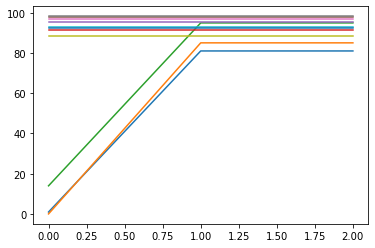

In [17]:
print(ref)
print(np.array(times_arr).mean())
print(last_times_copy)

import matplotlib.pyplot as plt
plt.plot(mses[::5000])
plt.show()

# Partie optionnelle

L'algorithme de Metropolis-Hasting est une autre methode de type MCMC qui utilise une distribution d'echantillonnage pour se deplacer dans l'espace des points consideres. Il s'agit de definir une distribution $q(y_{t+1}|x_t)$ de laquelle on sait generer un deplacement. L'algorithme procede alors de la maniere suivante: 


1.   Generer $y_{t+1}$ selon $q(y_{t+1}|x_t)$ 
2.   Calculer la probabilite dâ€™acceptation $\alpha(x_t,y_{t+1})=\min\left\{\frac{\pi(y_{t+1})q(x_t|y_{t+1})}{\pi(x_t)q(y_{t+1}|x_t)},1\right\} \,\!, \text{ avec } \pi(x_t) \text{ la densite de probabilite de } x_t$
3.   Prendre $x_{t+1}=\begin{cases} y_{t+1}, & \text{avec probabilite}\,\,\alpha \\ x_t, & \text{avec probabilite}\,\,1-\alpha \end{cases}$



Dans notre cas, on propose de travailler avec des deplacements correspondants a des permutations d'un temps d'infection a chaque iteration, comme dans le cadre du Gibbs Sampling. A chaque etape on choisit donc une variable a modifier, on choisit un nouveau temps pour cette variable et on calcule la densite correspondante. La probabilite d'acceptation est ensuite calculee selon cette densite et la probabilite du deplacement selon la distribution $q$ qui a servi a generer le nouveau temps d'infection. On se propose de choisir $maxT$ avec une probabilite de 0.1. La probabilite $q(t_v|t)$ pour $t< maxT$ est alors egale  a  $0.9\times \frac{1}{maxT}$.

Implementer l'approche d'echantillonnage par Metropolis-Hasting pour notre probleme d'estimation de probabilites marginales d'infection. 

In [25]:
def mh(graph, infections, burnin=1000, ref=None):
    return 0

maxT=10
ref=getProbaMC(graph,[0],maxT=10) 
rate=mh(graph,[(0,0)],burnin=100,ref=ref)
print(rate)